In [5]:
# Description: The program uses the recurrent artificial neural network called Long Short Term Memory (LSTM)
#              to predict the closing price of Apple corporation.

In [6]:
#Importing The Required Libraries
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
from datetime import date
plt.style.use('fivethirtyeight')

In [7]:
#Upgrading Pandas and Pandas DataReader
!pip install --upgrade pandas
!pip install --upgrade pandas-datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 86.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 29.7 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.0.2 which is incompatible.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
#Load The Required Stock Data
startDate = pd.to_datetime('2012-01-01')
endDate = pd.to_datetime(date.today())
df = web.DataReader('AAPL', data_source = 'stooq', start = startDate, end = endDate)
df = df.reindex(index=df.index[::-1])
print(df)

                Open      High       Low     Close        Volume
Date                                                            
2012-01-03   12.4779   12.5577   12.4520   12.5198  3.544907e+08
2012-01-04   12.4849   12.6235   12.4600   12.5866  3.051786e+08
2012-01-05   12.6314   12.7422   12.5627   12.7272  3.178972e+08
2012-01-06   12.7800   12.8717   12.7630   12.8608  3.734286e+08
2012-01-09   12.9525   13.0213   12.8289   12.8408  4.620092e+08
...              ...       ...       ...       ...           ...
2023-06-16  186.7300  186.9900  184.2700  184.9200  1.012562e+08
2023-06-20  184.4100  186.1000  184.4100  185.0100  4.979909e+07
2023-06-21  184.9000  185.4100  182.5901  183.9600  4.951570e+07
2023-06-22  183.7400  187.0450  183.6700  187.0000  5.124533e+07
2023-06-23  185.5500  187.5600  185.0100  186.6800  5.311700e+07

[2887 rows x 5 columns]


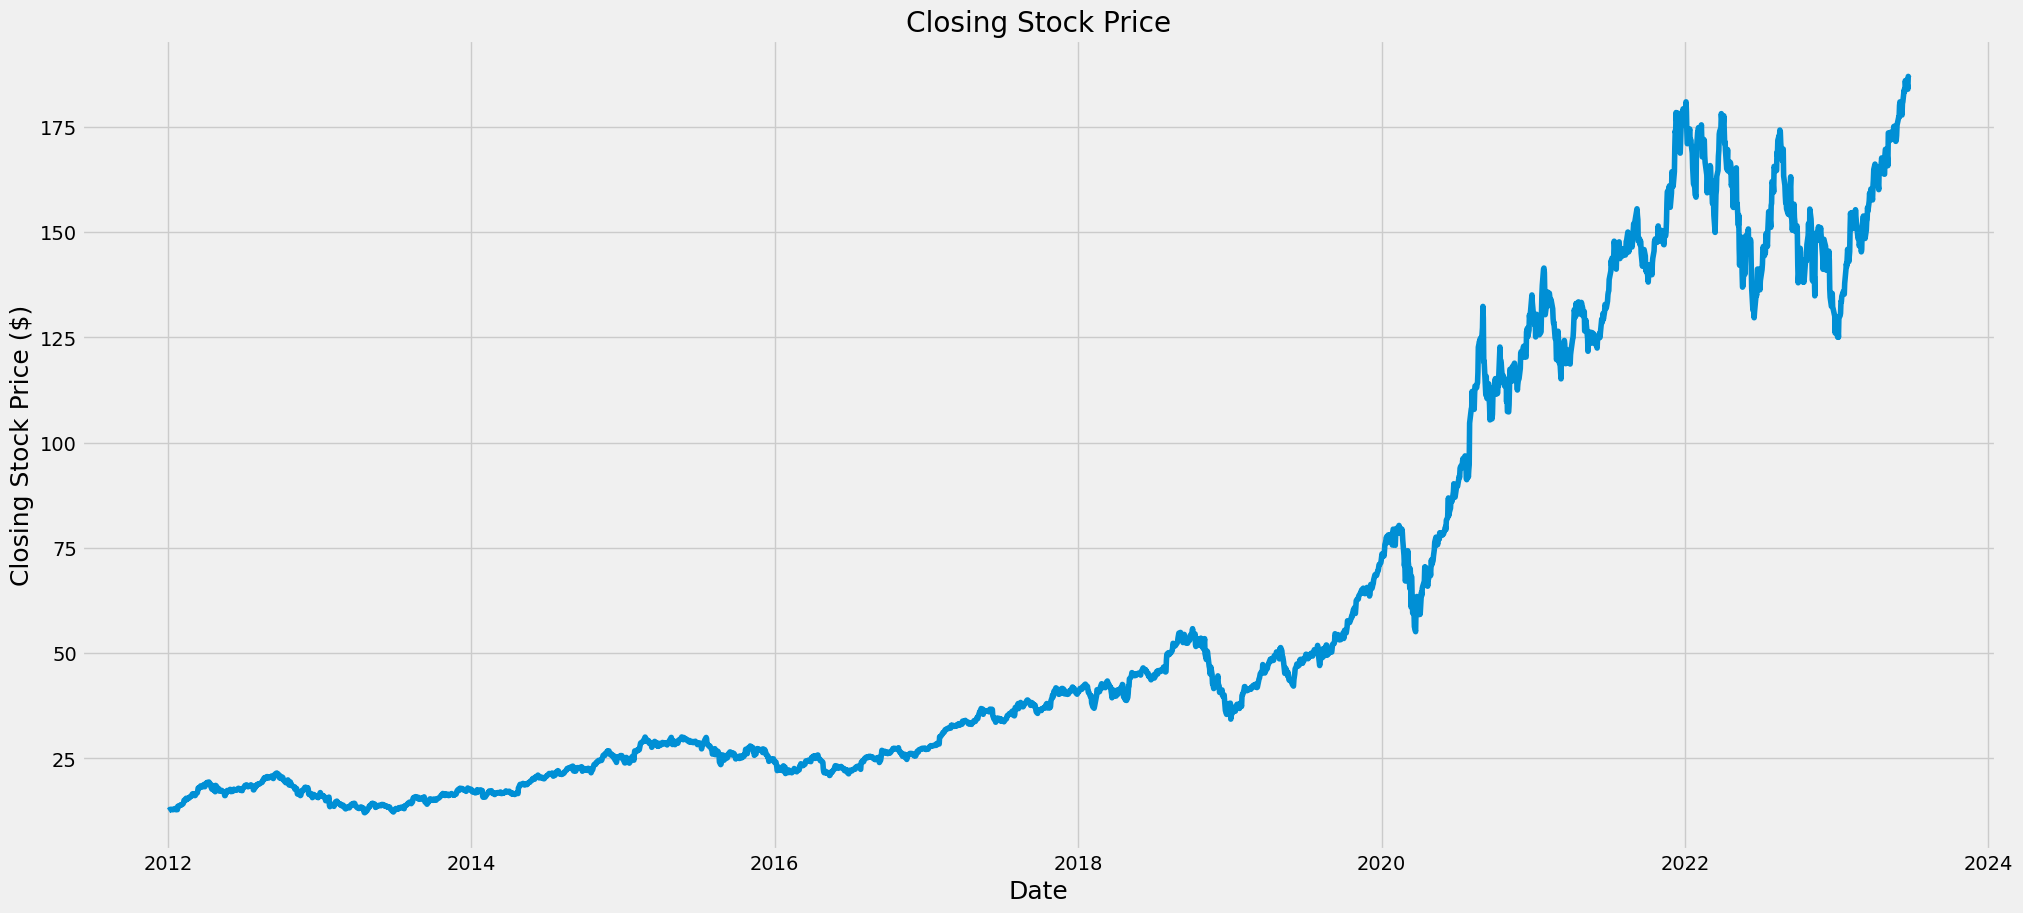

In [9]:
#Visualize the Closing Stock Price History
plt.figure(figsize=(22,10))
plt.title("Closing Stock Price")
plt.plot(df["Close"])
plt.xlabel("Date", fontsize = 18)
plt.ylabel("Closing Stock Price ($)", fontsize = 18)
plt.show()

In [10]:
#Create A New DataFrame with only Close column
data = df.filter(["Close"])
#Convert DataFrame To Numpy Array
dataset = data.values
# dataset = np.flip(dataset)
#Get The nUmber Of Rows To Train Teh Model On
training_data_len = math.ceil( len(dataset) * 0.8)

training_data_len

2310

In [11]:
#Scale The Data
scaler = MinMaxScaler(feature_range = (0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.00260438],
       [0.00298624],
       [0.00378996],
       ...,
       [0.9826222 ],
       [1.        ],
       [0.99817076]])

In [12]:
#Create The Scaled Trained DataSet
train_data = scaled_data[0:training_data_len, :]
x_train = []
y_train = []
for i in range(60, len(train_data)):
  x_train.append(train_data[i-60:i, 0])
  y_train.append(train_data[i, 0])

In [13]:
#Convert The x_train and y_train to numpy array
x_train, y_train = np.array(x_train), np.array(y_train)
#Resize The Arrays
x_train = np.reshape(x_train, ( x_train.shape[0], x_train.shape[1], 1))

In [14]:
#Build The LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences = False))
model.add(Dense(25))
model.add(Dense(1))

In [15]:
#Compile The Model
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
#Train The Model
model.fit(x_train, y_train, batch_size = 1, epochs = 1)

2250/2250 [==============================] - 96s 40ms/step - loss: 6.3746e-04


In [16]:
#Create A Training DataSet
test_data = scaled_data[training_data_len - 60 : , : ]
x_test = []
y_test = dataset[training_data_len : , : ]
for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

In [17]:
#Convert The data into Numpy Array
x_test = np.array(x_test)
#Reshape The Data
x_test = np.reshape(x_test, ( x_test.shape[0], x_test.shape[1], 1))

In [58]:
#Get The Model Predictions
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
#Get The Root Mean Squared Error
rmse = np.sqrt(np.mean(((predictions- y_test)**2)))
print("Error % = ", rmse) #Should Be Closer To Zero
print("Accuracy % = ", (100-rmse)) #Should Be Closer To 100

19/19 [==============================] - 1s 38ms/step
Error % =  9.634696542230413
Accuracy % =  90.36530345776958


<ipython-input-51-e737ba5bb5bc>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


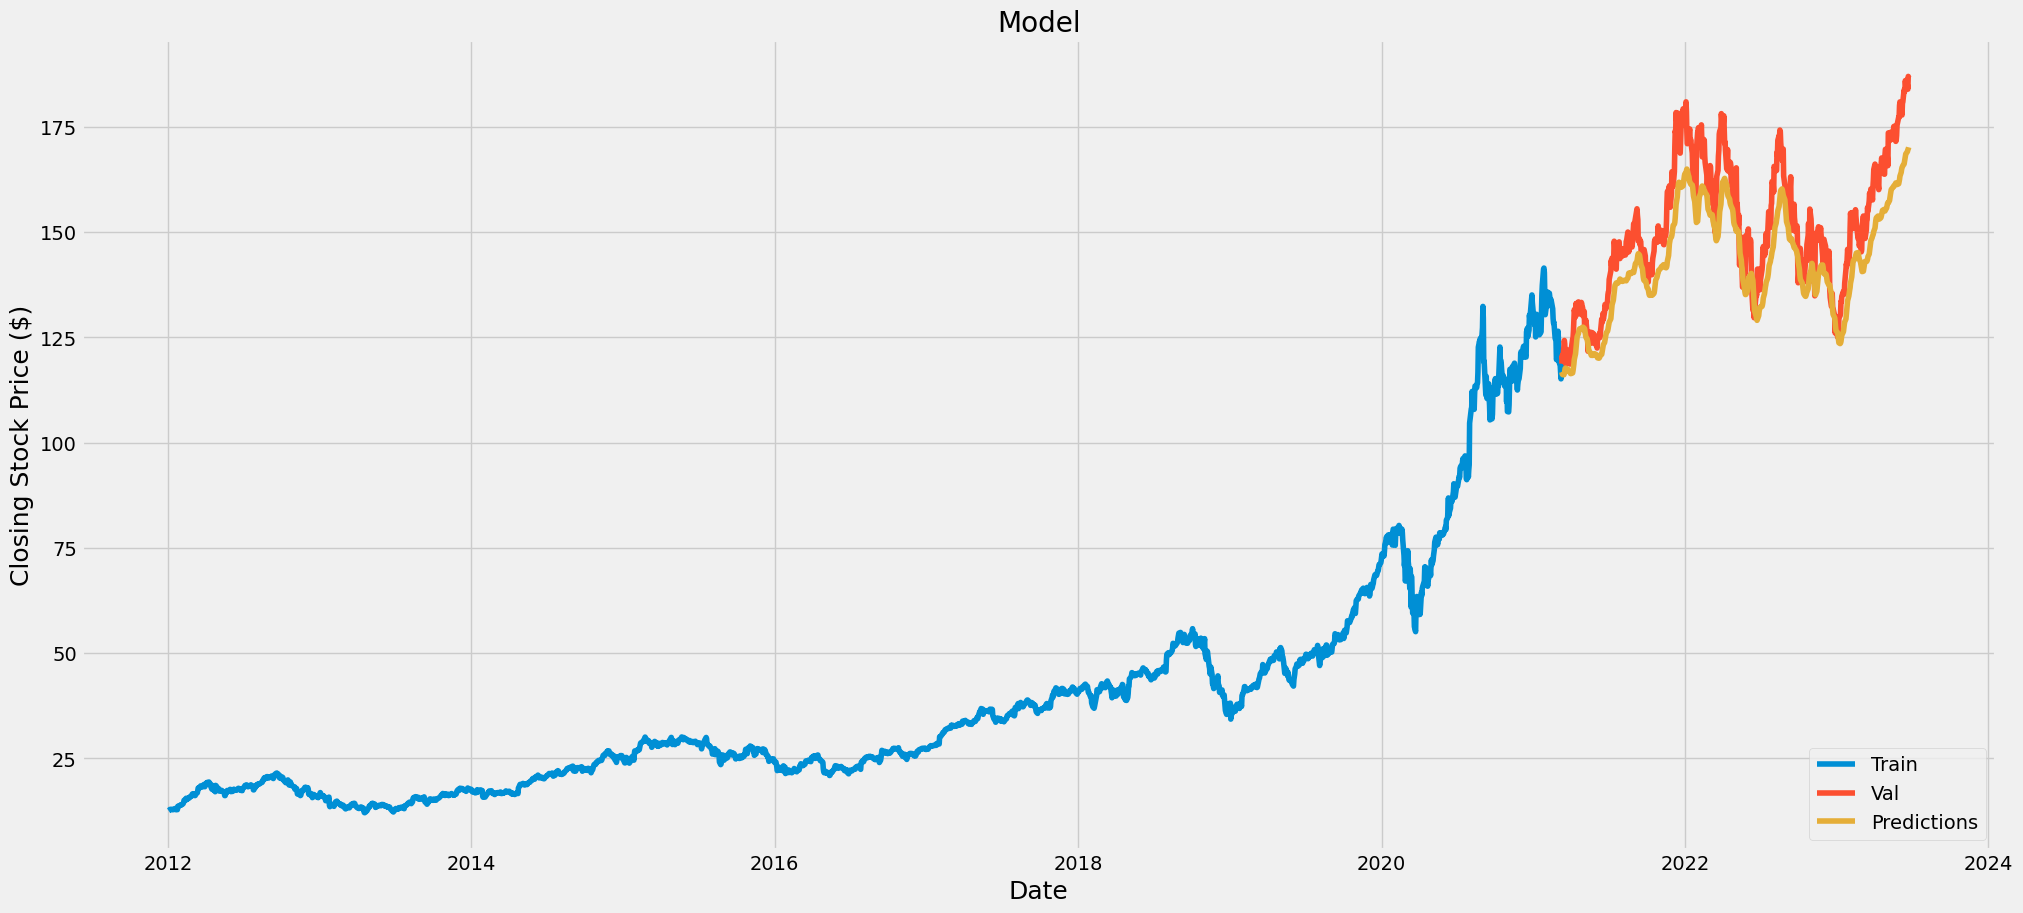

In [51]:
#Plot The Data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Visuavilize The Data
plt.figure(figsize=(22,10))
plt.title("Model")
plt.xlabel("Date", fontsize = 18)
plt.ylabel("Closing Stock Price ($)", fontsize = 18)
plt.plot(train["Close"])
plt.plot(valid[["Close", "Predictions"]])
plt.legend(["Train", "Val", "Predictions"], loc = "lower right")
plt.show()

In [52]:
#Comparing Actual and Predicted Values
valid

,Close,Predictions
Date,,
2021-03-10,118.748,116.736687
2021-03-11,120.692,116.281929
2021-03-12,119.764,116.157066
2021-03-15,122.695,116.109268
2021-03-16,124.271,116.414169
...,...,...
2023-06-16,184.920,168.587265
2023-06-20,185.010,169.135101
2023-06-21,183.960,169.561905


In [53]:
#Get The Quote
apple_quote = web.DataReader('AAPL', data_source = 'stooq', start = startDate, end = endDate)
#Create a new dataframe
new_df = apple_quote.filter(["Close"])
#Get The last 60 days price and convert the dataframe into an array
last_60_days = new_df[:60].values
#Scale the data to be values between 0 and 1
last_60_days_scaled = scaler.transform(last_60_days)
#Create an empty list
X_test = []
#Append the past 60 days
X_test.append(last_60_days_scaled)
#Convert the X_test dataset to numpy array
X_test = np.array(X_test)
#Reshape the test
X_test = np.reshape(X_test, ( X_test.shape[0], X_test.shape[1], 1 ))
#Get the predicted price
pred_price = model.predict(X_test)
#Undo the Scaling
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

1/1 [==============================] - 0s 28ms/step
[[153.97772]]


In [54]:
apple_quote['Close'][0]

186.68